In [1]:
import pandas as pd
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [2]:
df = pd.read_csv("customer_support_tickets.csv")
df.shape

(16337, 9)

In [3]:
df.dropna(subset = ['answer'],inplace = True)

In [4]:
# 1. Imports & Seed Setup

import pandas as pd
import numpy as np
import torch
import random

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [5]:
# 2. Load & Preprocess Data

# Combine text fields
df["text"] = df["subject"].fillna('') + " " + df["body"].fillna('')

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["department"])
num_classes = len(le.classes_)

# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=seed)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=seed)

In [6]:
# 3. Tokenizer Setup
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize_batch(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_attention_mask=True,
        return_tensors="pt"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# 4. PyTorch Dataset Class

class DeptDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [8]:
# 5. Dataloaders

train_ds = DeptDataset(train_df["text"], train_df["label"], tokenizer)
val_ds   = DeptDataset(val_df["text"], val_df["label"], tokenizer)
test_ds  = DeptDataset(test_df["text"], test_df["label"], tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

In [9]:
# 6. Model Definition

class BERTDeptClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

In [10]:
# 7. Optimizer, Scheduler, and Loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTDeptClassifier(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [11]:
# 8. Training & Evaluation Functions

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy


def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0

    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    return val_loss / len(loader), report


In [12]:
# 9. Training Loop with Logs & Scheduler

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_f1 = -1
patience = 3
epochs_since_improvement = 0
num_epochs = 50
checkpoint_path = "best_dept_model.pt"

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_report = eval_model(model, val_loader)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_report["accuracy"])

    f1 = val_report["weighted avg"]["f1-score"]
    prec = val_report["weighted avg"]["precision"]
    recall = val_report["weighted avg"]["recall"]

    improved = f1 > best_f1
    if improved:
        best_f1 = f1
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch:02d}: new best F1={best_f1:.4f}, saved checkpoint.")
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| F1: {f1:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f}")

    if epochs_since_improvement >= patience:
        print(f"Stopping early at epoch {epoch}.")
        break

Epoch 01: new best F1=0.3645, saved checkpoint.
Epoch 01 | Train Loss: 1.7377 | Val Loss: 1.6313 | F1: 0.3645 | Prec: 0.3650 | Recall: 0.4204


Epoch 02: new best F1=0.4254, saved checkpoint.
Epoch 02 | Train Loss: 1.5147 | Val Loss: 1.5158 | F1: 0.4254 | Prec: 0.4812 | Recall: 0.4592


Epoch 03: new best F1=0.4926, saved checkpoint.
Epoch 03 | Train Loss: 1.2419 | Val Loss: 1.4012 | F1: 0.4926 | Prec: 0.5071 | Recall: 0.5075


Epoch 04: new best F1=0.5504, saved checkpoint.
Epoch 04 | Train Loss: 0.9151 | Val Loss: 1.3613 | F1: 0.5504 | Prec: 0.5720 | Recall: 0.5565


Epoch 05: new best F1=0.6089, saved checkpoint.
Epoch 05 | Train Loss: 0.6107 | Val Loss: 1.3883 | F1: 0.6089 | Prec: 0.6191 | Recall: 0.6102


Epoch 06 | Train Loss: 0.3941 | Val Loss: 1.5205 | F1: 0.6010 | Prec: 0.6127 | Recall: 0.6068


Epoch 07: new best F1=0.6375, saved checkpoint.
Epoch 07 | Train Loss: 0.2747 | Val Loss: 1.5770 | F1: 0.6375 | Prec: 0.6491 | Recall: 0.6381


Epoch 08: new best F1=0.6691, saved checkpoint.
Epoch 08 | Train Loss: 0.1400 | Val Loss: 1.5362 | F1: 0.6691 | Prec: 0.6731 | Recall: 0.6701


Epoch 09: new best F1=0.6736, saved checkpoint.
Epoch 09 | Train Loss: 0.0836 | Val Loss: 1.6290 | F1: 0.6736 | Prec: 0.6819 | Recall: 0.6748


Epoch 10 | Train Loss: 0.0672 | Val Loss: 1.7669 | F1: 0.6632 | Prec: 0.6862 | Recall: 0.6605


Epoch 11: new best F1=0.6876, saved checkpoint.
Epoch 11 | Train Loss: 0.0413 | Val Loss: 1.7131 | F1: 0.6876 | Prec: 0.6964 | Recall: 0.6878


Epoch 12 | Train Loss: 0.0318 | Val Loss: 1.7986 | F1: 0.6825 | Prec: 0.6904 | Recall: 0.6830


Epoch 13 | Train Loss: 0.0244 | Val Loss: 1.8468 | F1: 0.6797 | Prec: 0.6830 | Recall: 0.6816


Epoch 14 | Train Loss: 0.0186 | Val Loss: 1.8463 | F1: 0.6841 | Prec: 0.6872 | Recall: 0.6850
Stopping early at epoch 14.


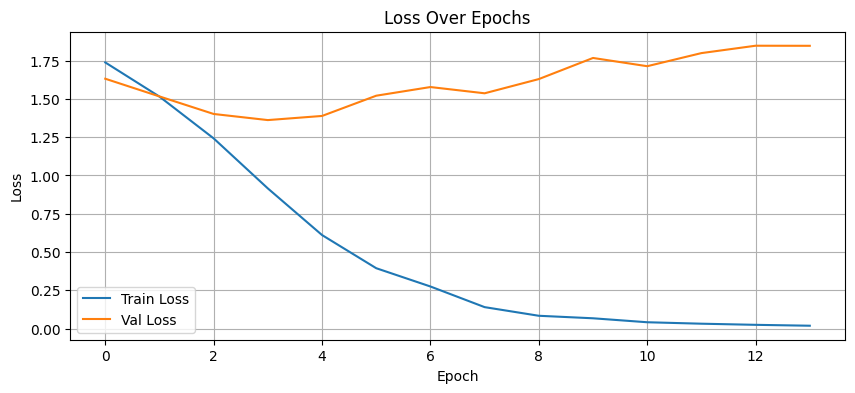

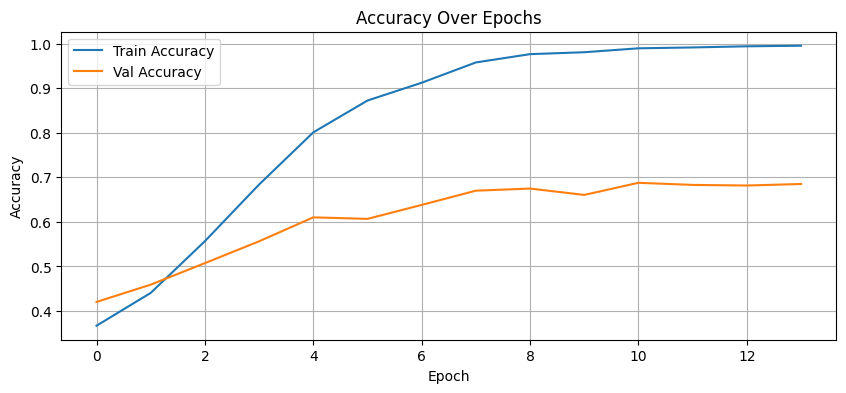

In [13]:
# 10. Plotting Metrics

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Test Classification Report:
                                  precision    recall  f1-score      support
Billing and Payments              0.944056  0.843750  0.891089   160.000000
Customer Service                  0.585284  0.726141  0.648148   241.000000
General Inquiry                   0.588235  0.416667  0.487805    24.000000
Human Resources                   0.740741  0.571429  0.645161    35.000000
IT Support                        0.623318  0.716495  0.666667   194.000000
Product Support                   0.692580  0.638436  0.664407   307.000000
Returns and Exchanges             0.812500  0.475610  0.600000    82.000000
Sales and Pre-Sales               0.750000  0.529412  0.620690    51.000000
Service Outages and Maintenance   0.859649  0.742424  0.796748    66.000000
Technical Support                 0.730539  0.772152  0.750769   474.000000
accuracy                          0.707466  0.707466  0.707466     0.707466
macro avg                         0.732690  0.643252  0.677

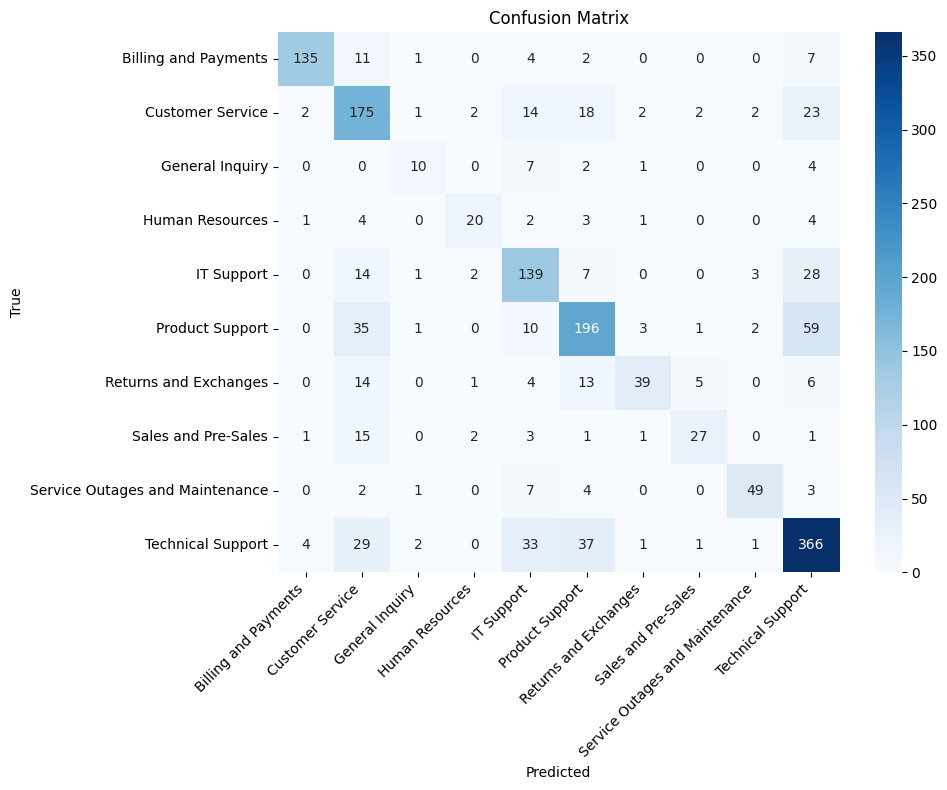

In [14]:
# 11. Final Test Evaluation and Confusion Matrix

model.load_state_dict(torch.load(checkpoint_path))
test_loss, test_report = eval_model(model, test_loader)

label_names = le.classes_.tolist()
report_named = {
    label_names[int(k)]: v for k, v in test_report.items() if k.isdigit()
}
for key in ["accuracy", "macro avg", "weighted avg"]:
    report_named[key] = test_report[key]

print("Test Classification Report:\n",
      pd.DataFrame(report_named).transpose())

# Confusion Matrix

def get_preds_and_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

all_preds, all_labels = get_preds_and_labels(model, test_loader)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()